In [ ]:
#default_exp srcnn_bn

# SRCNN+BN: Image super-resolution using deep convolutional networks + Batch Normalization

https://arxiv.org/abs/1501.00092

31 Dec 2014

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [4]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## SRCNN: Image super-resolution using deep convolutional networks

In [5]:
# export
class SRCNN_BN(nn.Module):
    """ Image super-resolution using deep convolutional networks """

    def __init__(self):
        super(SRCNN_BN, self).__init__()
        self.conv1 = conv_layer(ni=3, nf=64, ks=9, stride=1, padding=4)
        self.conv2 = conv_layer(ni=64, nf=32, ks=1, stride=1, padding=0)
        self.conv3 = conv_layer(ni=32, nf=3, ks=5, stride=1, padding=2, use_activ=False)

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        return self.conv3(h)

## DataBunch

In [6]:
train_hr = div2k_train_hr_crop_256

In [7]:
in_size = 256
out_size = 256
scale = 4
bs = 10

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


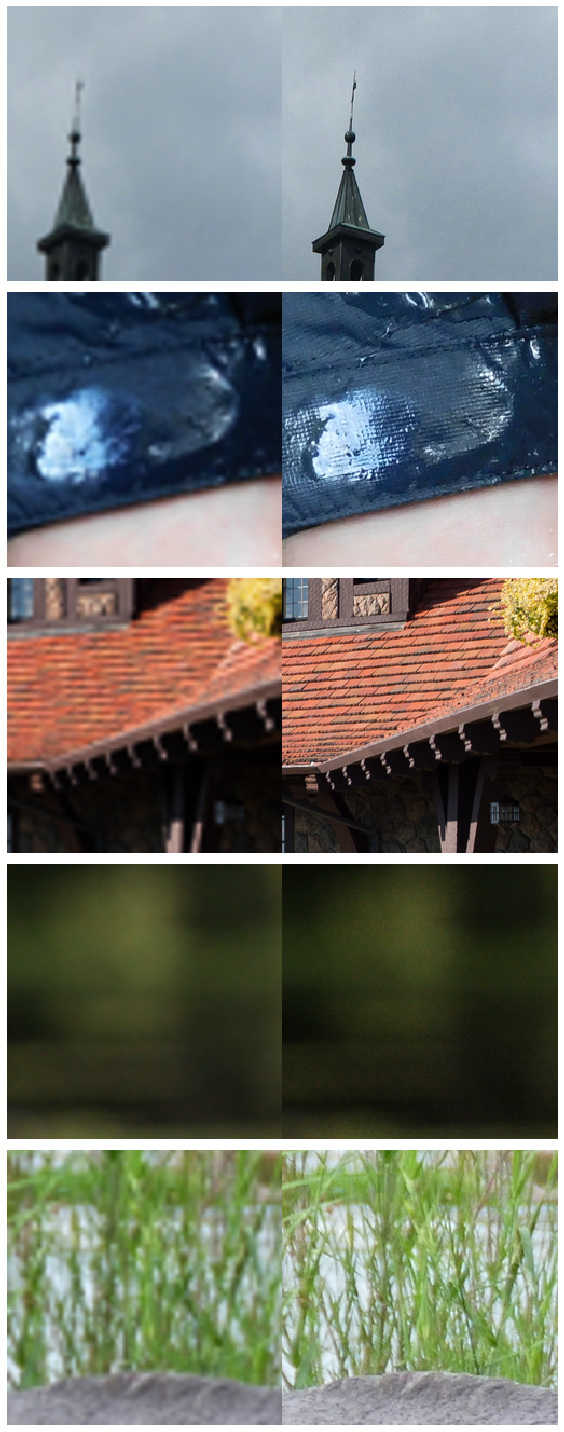

In [8]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, bs=bs, seed=seed)
print(data)
data.show_batch()

## Training

In [9]:
model = SRCNN_BN()
loss_func = MSELossFlat()
metrics = [m_psnr, m_ssim]
learn = Learner(data, model, loss_func=loss_func, metrics=metrics)
model_name = model.__class__.__name__

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 2.29E-01


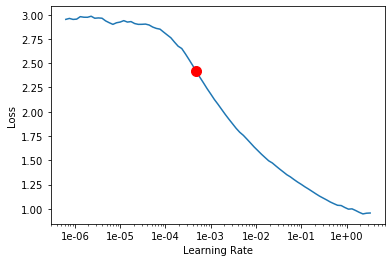

In [11]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [12]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [14]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

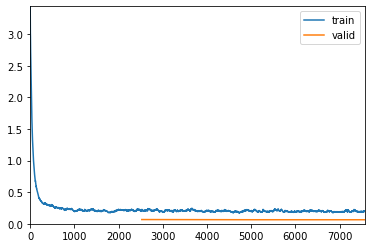

Better model found at epoch 0 with valid_loss value: 0.06709658354520798.
Better model found at epoch 1 with valid_loss value: 0.06429817527532578.
Better model found at epoch 2 with valid_loss value: 0.06404571235179901.


In [15]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

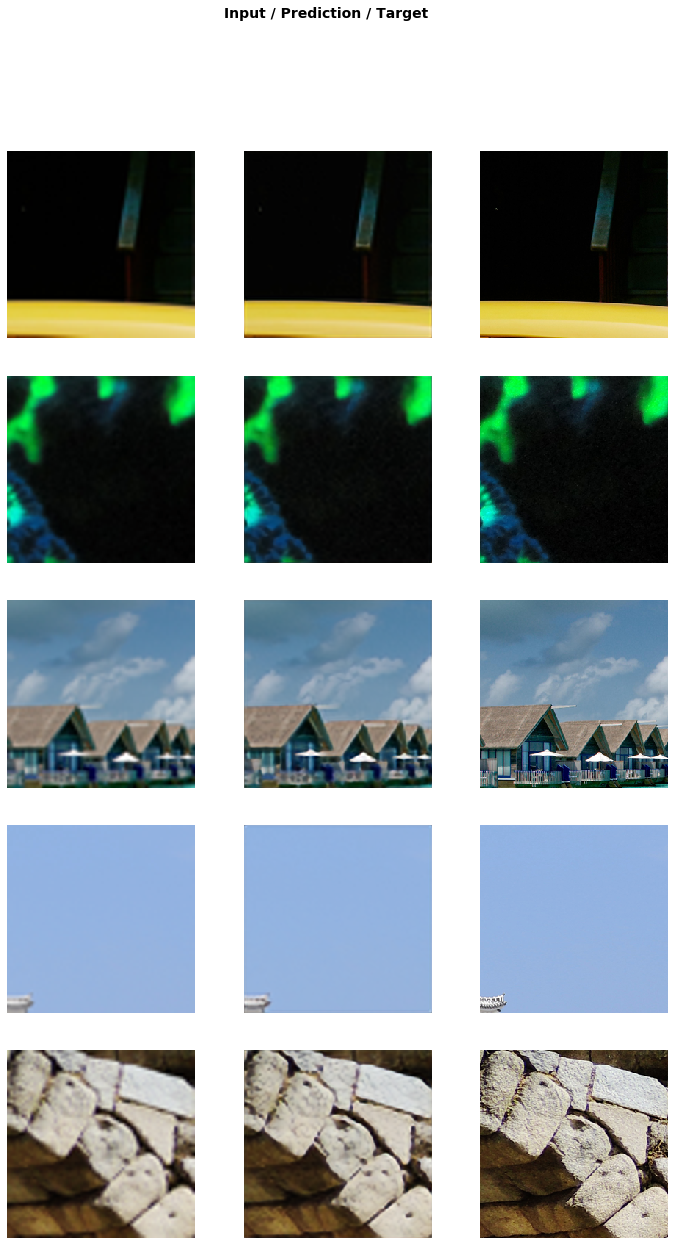

In [43]:
learn.show_results()

## Test

In [18]:
test_hr = set14_hr

In [20]:
il_test_x = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size, scale=4, sizeup=True))
il_test_y = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size))

In [21]:
_ = learn.load(save_fname)

bicubic: PSNR:24.11,SSIM:0.7822
SRCNN_BN:	 PSNR:24.40,SSIM:0.7991


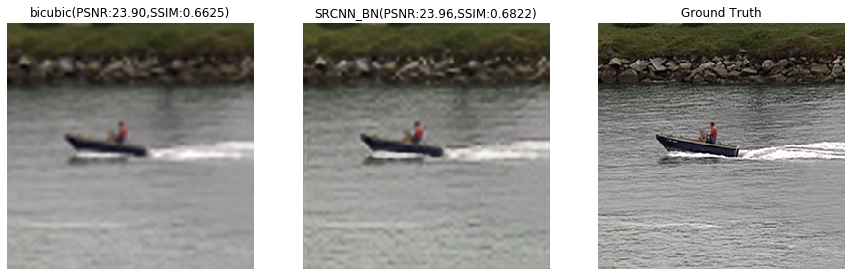

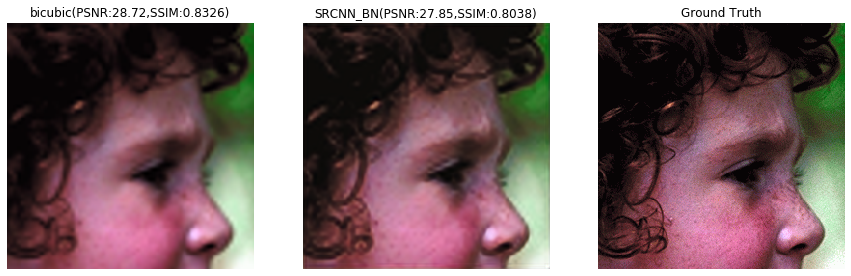

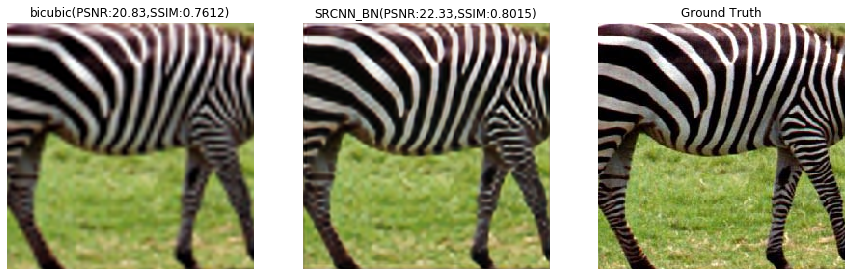

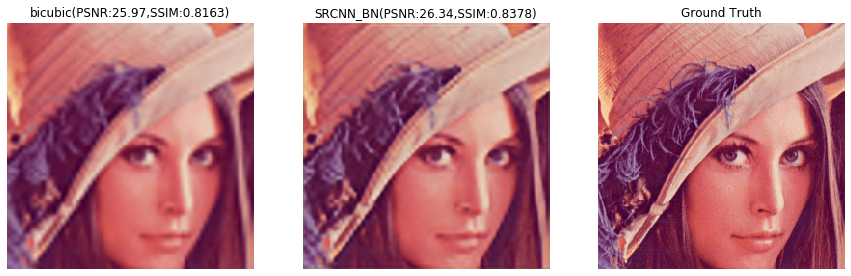

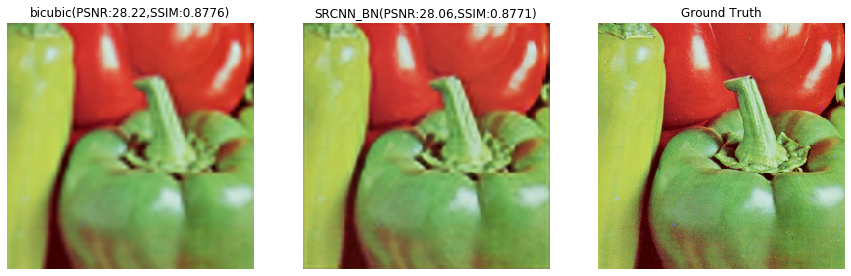

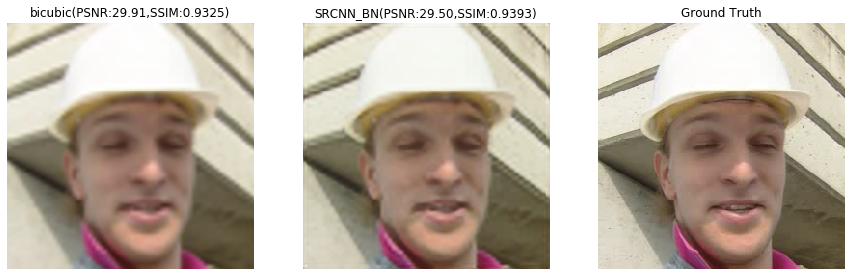

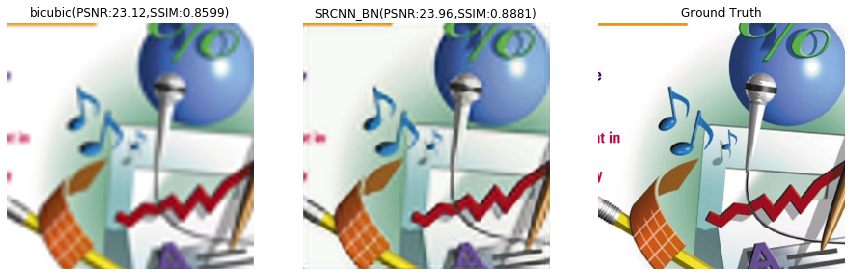

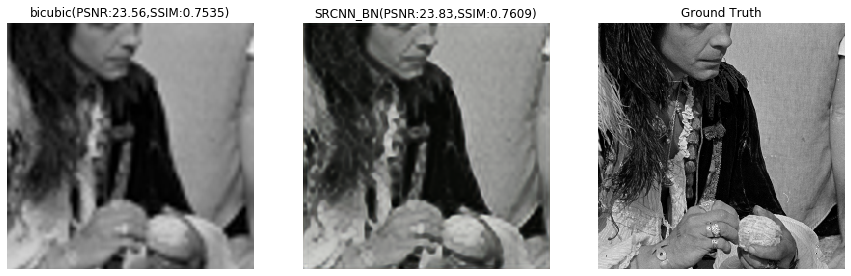

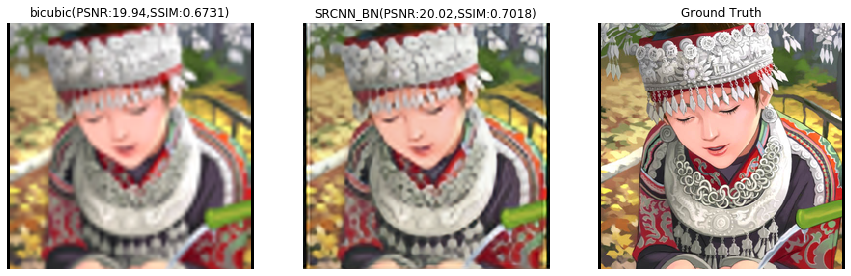

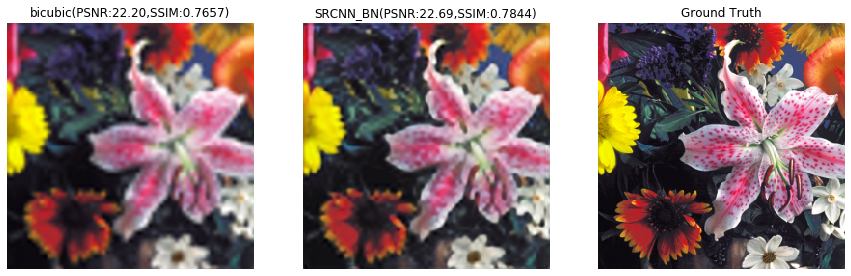

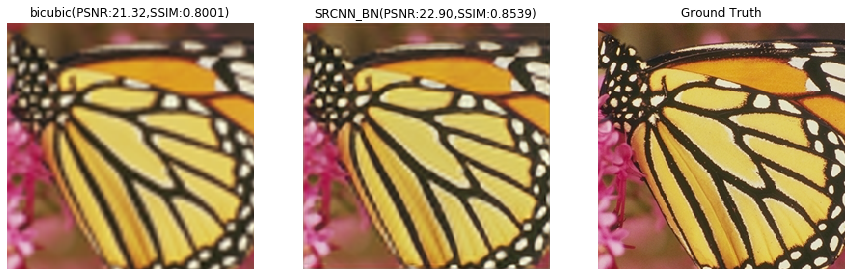

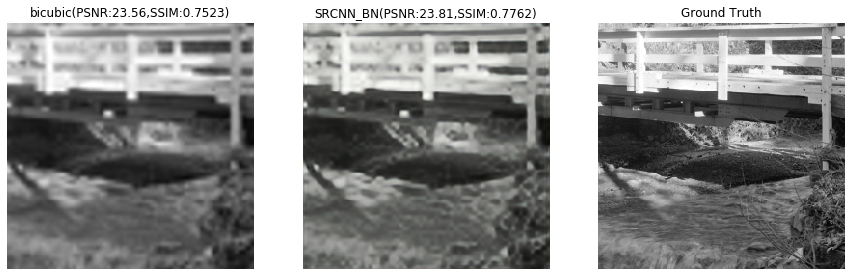

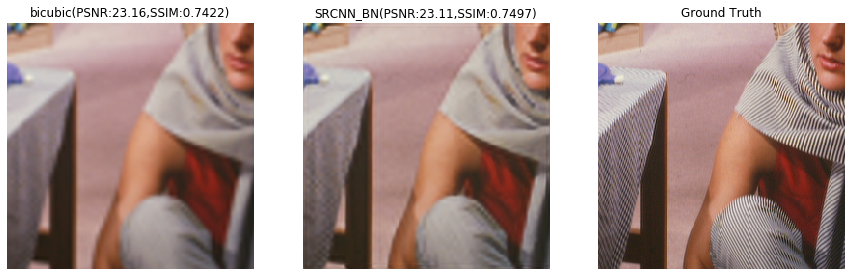

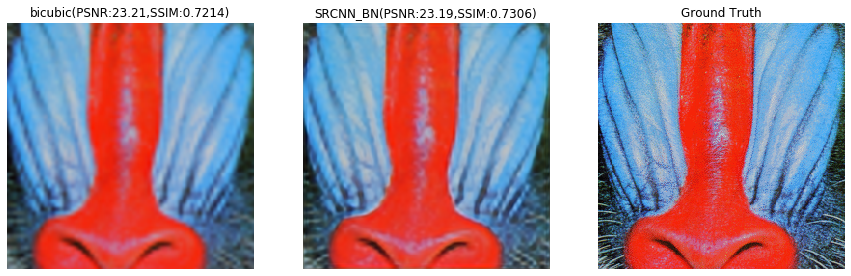

In [22]:
sr_test(learn, il_test_x, il_test_y, model_name)

## Report

In [23]:
model

SRCNN_BN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [24]:
learn.summary()

SRCNN_BN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 256, 256]       15,552     True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
Conv2d               [32, 256, 256]       2,048      True      
______________________________________________________________________
ReLU                 [32, 256, 256]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 256, 256]       64         True      
______________________________________________________________________
Conv2d               [3, 256, 256]        2,400      True      
_____________________________________________________